In [1]:
import time
import itertools

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from selectinf.Simulation.simulation_helpers import (one_sim_mode, one_sim_mode_serial,
                                generate_gaussian_instance_nonlinear_interaction_simple,
                                generate_gaussian_instance_nonlinear_interaction,
                                )
from selectinf.Simulation.spline_instance import (generate_gaussian_instance_from_bspline_interaction, generate_gaussian_instance_nonlinear_interaction,
 gaussian_group_polynomial_interaction_instance)
from selectinf.group_lasso_query import (group_lasso,
                                         split_group_lasso)
from selectinf.Simulation.simulation_helpers import *
from selectinf.Simulation.spline_instance import *
from multiprocessing import Pool

from functools import partial

/Users/yilingh/Desktop/PhD/SI_Codes/SI-Interaction/env3/lib/python3.9/site-packages/regreg/atoms/slope.py:16: UserWarning: unable to import isotonic regression from sklearn, using a pure python implementation
  warn('unable to import isotonic regression from sklearn, using a pure python implementation')


In [2]:
def plot_ecdf(data):
    # Step 2: Sort the data
    data_sorted = np.sort(data)
    
    # Step 3: Calculate the empirical CDF
    # For each point, the CDF value is the proportion of data points less than or equal to that point
    cdf_values = np.arange(1, len(data_sorted) + 1) / len(data_sorted)
    
    # Step 4: Plot the empirical CDF
    plt.figure(figsize=(8, 8))
    plt.step(data_sorted, cdf_values, where='post', label='Empirical CDF')
    plt.title('Empirical Cumulative Distribution Function')
    # Add a y=x line
    line_data = np.linspace(0, 1, 1000)
    plt.plot(line_data, line_data, label='Uniform CDF', linestyle='--')
    plt.xlabel('Data Points')
    plt.ylabel('CDF')
    plt.grid(True)
    plt.legend()
    plt.show()

In [3]:
_cov_cache = {}
def _design(n, p, rho, equicorrelated):
    """
    Create an equicorrelated or AR(1) design.
    """
    if equicorrelated:
        X = (np.sqrt(1 - rho) * np.random.standard_normal((n, p)) +
             np.sqrt(rho) * np.random.standard_normal(n)[:, None])

        def equi(rho, p):
            if ('equi', p, rho) not in _cov_cache:
                sigmaX = (1 - rho) * np.identity(p) + rho * np.ones((p, p))
                cholX = np.linalg.cholesky(sigmaX)
                _cov_cache[('equi', p, rho)] = sigmaX, cholX
            return _cov_cache[('equi', p, rho)]

        sigmaX, cholX = equi(rho=rho, p=p)
    else:
        def AR1(rho, p):
            if ('AR1', p, rho) not in _cov_cache:
                idx = np.arange(p)
                cov = rho ** np.abs(np.subtract.outer(idx, idx))
                _cov_cache[('AR1', p, rho)] = cov, np.linalg.cholesky(cov)
            cov, chol = _cov_cache[('AR1', p, rho)]
            return cov, chol

        sigmaX, cholX = AR1(rho=rho, p=p)
        X = np.random.standard_normal((n, p)).dot(cholX.T)
    return X, sigmaX, cholX

In [4]:
def block_AR_interaction(rho, n = 100, p=10, nblocks=1, SNR=1, inter_signal=1,
                         block_s=3, s_inter_list = [(0,1)], 
                         structure="stronghierarchy",
                         zero_main=True, center= False, scale=False):
    for b in range(nblocks):
        if b == 0:
            X_signal, sigmaX = _design(n, block_s, rho, equicorrelated=False)[:2]
        else:
            X_b, sigmaX = _design(n, block_s, 0, equicorrelated=False)[:2]
            X_signal = np.concatenate([X_signal, X_b], axis=1)
    X_noise, sigmaX = _design(n, p-block_s*nblocks, 0, equicorrelated=False)[:2]
    X = np.concatenate([X_signal, X_noise], axis=1)
    # Sample a support of size s for beta
    beta = np.zeros(p)
    signal = np.atleast_1d(1)
    
    if s_inter_list is None:
        s_inter_list = []
        for b in range(nblocks):
            s_inter_list.append((b*block_s, b*block_s+1))
    s_inter = len(s_inter_list)
    active_inter_list = s_inter_list
        
    data_interaction = {}
    for i in range(p):
        for j in range(i + 1, p):
            data_interaction[(i, j)] = X[:, i] * X[:, j]
            if center:
                data_interaction[(i, j)] = data_interaction[(i, j)] - np.mean(data_interaction[(i, j)])
            if scale:
                scaling = np.std(data_interaction[(i, j)]) * np.sqrt(n)
                data_interaction[(i, j)] = data_interaction[(i, j)] / scaling

    gamma = np.ones((s_inter,)) * inter_signal

    if zero_main:
        for b in range(nblocks):
            beta[0+b*3] = - inter_signal * rho / (1 + rho**2)
            beta[1+b*3] = - inter_signal * rho / (1 + rho**2)
            beta[2+b*3] = 0 #- inter_signal * rho**3
    else:
        for b in range(nblocks):
            beta[0+b*3] = 1
            beta[1+b*3] = 1
            beta[2+b*3] = 1 #- inter_signal * rho**3
    
    active = np.zeros(p, bool)
    active[beta != 0] = True
    beta /= np.sqrt(n)
    gamma /= np.sqrt(n)

    if center:
        X -= X.mean(0)[None, :]

    if scale:
        # ----SCALE----
        # scales X by sqrt(n) and sd
        # if we need original X, uncomment the following line
        # X_raw = X
        # ----SCALE----
        scaling = X.std(0) * np.sqrt(n)
        X /= scaling[None, :]
        beta *= np.sqrt(n)
        gamma *= np.sqrt(n)

    # interaction * gamma
    interaction_proj = np.zeros((n,))
    # Construct (dense) design of interactions:
    for i in range(s_inter):
        pair = active_inter_list[i]
        interaction_proj += data_interaction[(pair[0], pair[1])] * gamma[i]

    Y_mean = X.dot(beta) + interaction_proj
    
    if SNR > 0:
        noise_sd = (np.std(X.dot(beta) + interaction_proj) /
                    np.sqrt(SNR))
    else:
        noise_sd = 1
    print("noise_sd:", noise_sd)

    Y = Y_mean + np.random.normal(size=(n,), scale=noise_sd)
    
    groups = np.arange(p)

    return (data_interaction, Y, Y_mean, X, groups,
            active, None, active_inter_list)
    

In [8]:
def point_plot_multimetrics(oper_char_df, x_axis='p', hue='method', plot_size=False,
                            metric_list=None):
    oper_char_df = oper_char_df.copy()
    sns.set_style("white", {'axes.facecolor': 'white', 
                            'axes.grid': True,
                            'axes.linewidth': 2.0,
                            'grid.linestyle': u'--',
                            'grid.linewidth': 4.0,
                            'xtick.major.size': 5.0,
                           })
    #sns.histplot(oper_char_df["sparsity size"])
    #plt.show()
    n_subplots = len(metric_list)
    #cols = int(np.ceil(n_subplots / 2))
    cols = n_subplots
    
    fig = plt.figure(figsize=(cols * 5, 6))
    
    my_palette = {"MLE": "#48c072", 
                  "Naive": "#fc5a50",
                  "Data Splitting": "#03719c"}
    
    # Create each subplot
    for i in range(1, n_subplots + 1):
        # ax = fig.add_subplot(2, cols, i) #two rows
        ax = fig.add_subplot(1, cols, i) #one row
        if hue is not None:
            sns.pointplot(x=oper_char_df[x_axis], 
                          y=oper_char_df[metric_list[i-1]], 
                          hue = oper_char_df[hue],
                          markers='o',
                          palette=my_palette,
                          ax=ax)
        else:
            sns.pointplot(x=oper_char_df[x_axis], 
                          y=oper_char_df[metric_list[i-1]], 
                          markers='o',
                          palette=my_palette,
                          ax=ax)
        if metric_list[i-1] == 'coverage rate':
            ax.set_ylim([0, 1])
            ax.axhline(y=0.9, color='k', linestyle='--', linewidth=1)
        if metric_list[i-1] == 'coverage rate':
            ax.set_ylabel("Coverage Rate", fontsize=15)  # remove y label, but keep ticks
        elif metric_list[i-1] == 'avg length':
            #ax.set_ylim([0, 2.5])
            ax.set_ylabel("Average Length", fontsize=15)  # remove y label, but keep ticks
        else: 
            ax.set_ylabel(metric_list[i-1], fontsize=15)  # remove y label, but keep ticks
        ax.legend().set_visible(False)
        #ax.set_title(f'Category: {metric_list[i-1]}')
        
        # ax.set_xlabel('Signal Strength', fontsize=15)
        if x_axis == 'signal':
            ax.set_xlabel('Signal Strength', fontsize=15)
        elif x_axis == 'm':
            ax.set_xlabel('Sparsity', fontsize=15)

    handles, labels = ax.get_legend_handles_labels()
    # fig.tight_layout(pad=0.4, w_pad=0.5, h_pad=1.2)
    
    fig.subplots_adjust(bottom=0.2)
    fig.legend(handles, labels, loc='lower center', ncol=n_subplots,
               prop={'size': 15})

    #cov_plot.legend_.remove()
    #len_plot.legend_.remove()

    #plt.suptitle("Changing n,p")
    plt.subplots_adjust(wspace=0.3, hspace=0.5)
    plt.show()

In [9]:
(data_interaction, Y, Y_mean, X, groups,
 active, active_inter_adj, active_inter_list)\
    = block_AR_interaction(rho=0.8, n = 200, p=50, SNR=1, inter_signal=1,
                           block_s=1, nblocks=1, s_inter_list = None,
                           structure="stronghierarchy",
                           zero_main=True, center= False, scale=False)

noise_sd: 0.08124337410091795


In [83]:
active_inter_list

[(0, 1), (3, 4), (6, 7)]

[0, 1, 6, 10, 12, 15, 17, 21, 32, 34, 36, 39, 41]
13.0
Naive Selection Size: 1


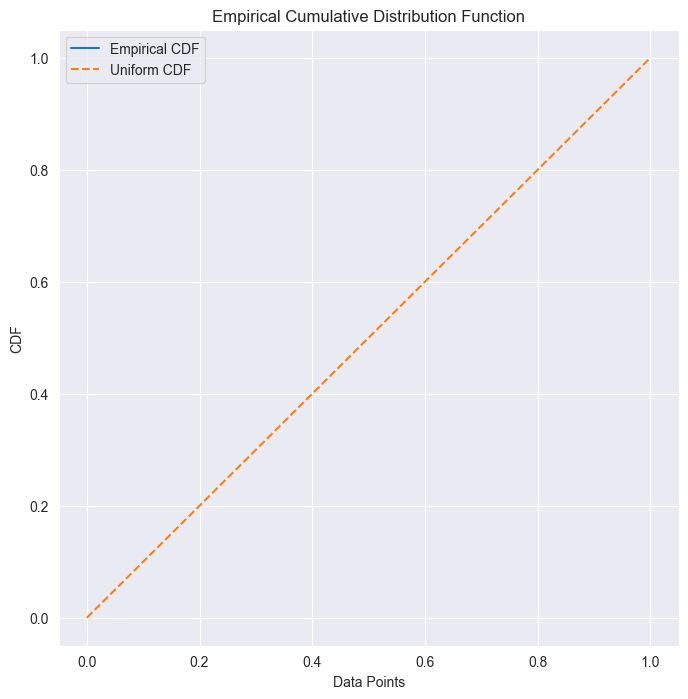

In [11]:
const = group_lasso.gaussian
coverages, lengths, selected_inter, p_values, targets \
    = naive_inference_inter(X=X, Y=Y, groups=groups,
                            Y_mean=Y_mean, const=const,
                            n_features=10, interactions=data_interaction,
                            weight_frac=5, level=0.9, mode='stronghierarchy',
                            solve_only=False, continued=False,
                            parallel=False, p_val=True, intercept=False,
                            target_ids=active_inter_list)
if coverages is not None:
    plot_ecdf(p_values)

18.0
DS Selection Size: 1


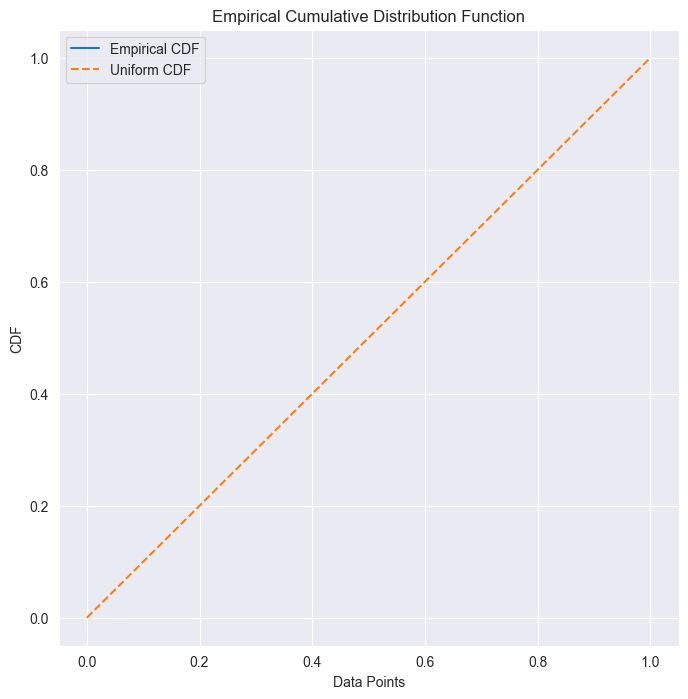

In [12]:
const = group_lasso.gaussian
coverages, lengths, selected_inter, p_values, targets \
    = data_splitting_inter(X=X, Y=Y, groups=groups,
                            Y_mean=Y_mean, const=const,
                            n_features=10, interactions=data_interaction,
                            weight_frac=5, level=0.9, mode='stronghierarchy',
                            solve_only=False, continued=False,
                            parallel=False, p_val=True, intercept=False,
                            target_ids=active_inter_list)
if coverages is not None:
    plot_ecdf(p_values)

In [13]:
targets

[0.07071067811865475]

In [14]:
np.mean(coverages)

1.0

In [15]:
pairs = [(1,2), (2,3), (1,4)]
p_list = [(2,2), (1,4), (2,3), (1,3)]

In [16]:
p_list_hat = [p for p in p_list if p in pairs]

In [17]:
p_list_hat

[(1, 4), (2, 3)]

In [76]:
oper_char = {}
oper_char["coverage rate"] = []
oper_char["avg length"] = []
oper_char["method"] = []
oper_char["rho"] = []
oper_char["target"] = []
oper_char["pval"] = []
const = group_lasso.gaussian
p = 50
rho = 0.5
signal = 0
weights = 5
for i in range(300):
    for rho in [0.25, 0.5, 0.75]:
        while True:
            (data_interaction, Y, Y_mean, X, groups,
             active, active_inter_adj, active_inter_list) \
                = block_AR_interaction(rho=rho, n=150, p=p, block_s=3, nblocks=3,
                                       SNR=1, inter_signal=signal, s_inter_list=None,
                                       structure="stronghierarchy",
                                       zero_main=False, center=False, scale=False)
            noselection = False
            const = group_lasso.gaussian
            if not noselection:
                coverages, lengths, selected_inter, p_values, targets \
                    = naive_inference_inter(X=X, Y=Y, groups=groups,
                                            Y_mean=Y_mean, const=const,
                                            n_features=p, interactions=data_interaction,
                                            weight_frac=weights, level=0.9, mode='weakhierarchy',
                                            solve_only=False, continued=False,
                                            parallel=False, p_val=True, 
                                            return_pivot=True,
                                            intercept=False,
                                            target_ids=active_inter_list)
                noselection = coverages is None
                
            if not noselection:
                coverages_ds, lengths_ds, selected_inter_ds, p_values_ds, targets_ds \
                    = data_splitting_inter(X=X, Y=Y, groups=groups,
                                            Y_mean=Y_mean, const=const,
                                           proportion=0.5,
                                            n_features=p, interactions=data_interaction,
                                            weight_frac=weights, level=0.9, mode='weakhierarchy',
                                            solve_only=False, continued=False,
                                            parallel=False, p_val=True, 
                                           return_pivot=True,
                                           intercept=False,
                                            target_ids=active_inter_list)
                noselection = coverages_ds is None
            
            if not noselection:
                coverages_MLE, lengths_MLE, selected_inter_MLE, p_values_MLE, targets_MLE \
                    = MLE_inference_inter(X=X, Y=Y, Y_mean=Y_mean, groups=groups,
                                          n_features=p, interactions=data_interaction,
                                          intercept=False,
                                          proportion=0.5, weight_frac=weights, level=0.9,
                                          mode='weakhierarchy',
                                          solve_only=False, continued=False, parallel=False,
                                          p_val=True, 
                                          return_pivot=True,
                                          target_ids=active_inter_list)
                print("target naive:", targets)
                print("target ds:", targets_ds)
                print("target MLE:", targets_MLE)
                noselection = coverages_MLE is None
            
            if not noselection:
                # Naive
                oper_char["coverage rate"].append(np.mean(coverages))
                oper_char["avg length"].append(np.mean(lengths))
                oper_char["method"].append('Naive')
                oper_char["rho"].append(rho)
                oper_char["target"].append(targets[0])
                oper_char["pval"].append(p_values[0])
    
                # Data splitting
                oper_char["coverage rate"].append(np.mean(coverages_ds))
                oper_char["avg length"].append(np.mean(lengths_ds))
                oper_char["method"].append('Data Splitting')
                oper_char["rho"].append(rho)
                oper_char["target"].append(targets_ds[0])
                oper_char["pval"].append(p_values_ds[0])
                
                # MLE
                oper_char["coverage rate"].append(np.mean(coverages_MLE))
                oper_char["avg length"].append(np.mean(lengths_MLE))
                oper_char["method"].append('MLE')
                oper_char["rho"].append(rho)
                oper_char["target"].append(targets_MLE[0])
                oper_char["pval"].append(p_values_MLE[0])
                
                break

noise_sd: 0.2625812024752384
[0, 1, 2, 3, 4, 5, 6, 7, 8, 28, 36, 40, 44]
13.0
Naive Selection Size: 0
23.0
DS Selection Size: 0
13.0
0 th interaction out of 3
Z-values: 0.458659564946032
1 th interaction out of 3
Z-values: 0.19210041274752646
2 th interaction out of 3
Z-values: 0.29528026550661285
target naive: [1.474514954580286e-17, -1.734723475976807e-17, -2.3418766925686896e-17]
target ds: [-4.7704895589362195e-18, -2.42861286636753e-17, 1.0408340855860843e-17]
target MLE: [ 1.64798730e-17 -1.08420217e-17 -7.80625564e-18]
noise_sd: 0.2978553946914187
[0, 1, 2, 3, 4, 5, 6, 7, 8, 12, 14, 18, 20, 22, 25, 27, 28, 31, 42, 43, 46]
21.0
Naive Selection Size: 2
24.0
DS Selection Size: 1
16.0
0 th interaction out of 3
Z-values: 1.5041401266927452
1 th interaction out of 3
Z-values: 1.3056631613787875
2 th interaction out of 3
Z-values: -0.11797609917905427
target naive: [6.938893903907228e-18, -1.0842021724855044e-17, 2.7755575615628914e-17]
target ds: [0.0193988227869374, 0.023924325125170

In [177]:
"""
rho=0.5, n=200, p=50, block_s=3, nblocks=1,
                                   SNR=1., inter_signal=1, s_inter_list=None,
                                   structure="stronghierarchy",
                                   zero_main=True, center=False, scale=False
naive undercovers
"""

'\nrho=0.5, n=200, p=50, block_s=3, nblocks=1,\n                                   SNR=1., inter_signal=1, s_inter_list=None,\n                                   structure="stronghierarchy",\n                                   zero_main=True, center=False, scale=False\nnaive undercovers\n'

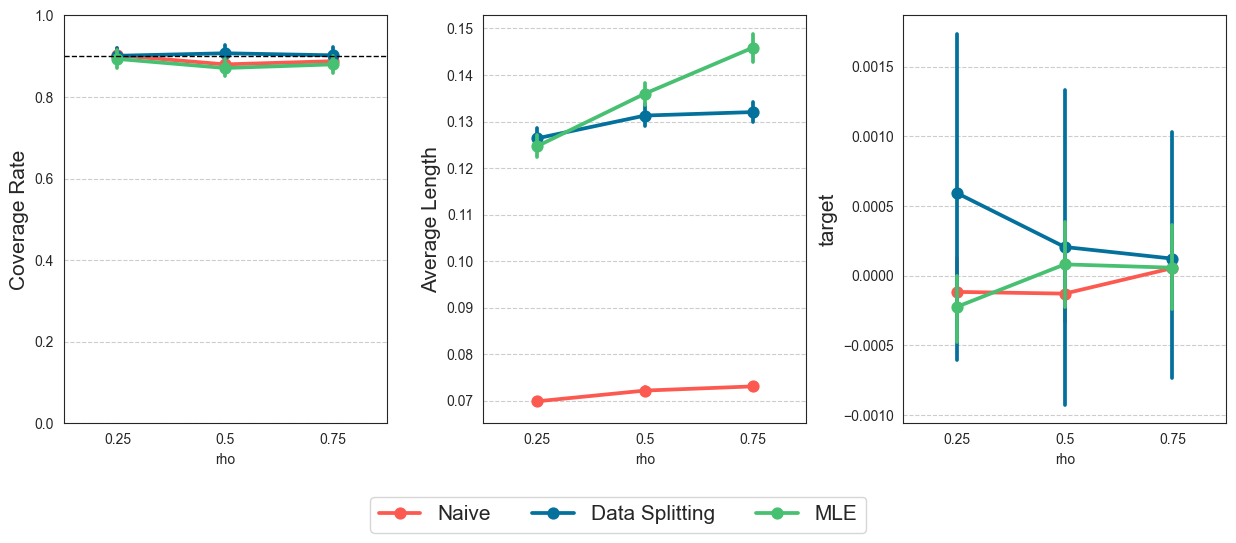

In [77]:
point_plot_multimetrics(oper_char_df=pd.DataFrame(oper_char),
                        x_axis="rho",
                        hue="method",
                        metric_list=["coverage rate", "avg length",
                                     "target"])

In [78]:
pd.DataFrame(oper_char)

,coverage rate,avg length,method,rho,target,pval
0,1.000000,0.081976,Naive,0.25,1.474515e-17,0.172091
1,1.000000,0.118253,Data Splitting,0.25,-4.770490e-18,0.387511
2,1.000000,0.166095,MLE,0.25,1.647987e-17,0.676761
3,0.333333,0.071569,Naive,0.50,6.938894e-18,0.874120
4,0.666667,0.151915,Data Splitting,0.50,1.939882e-02,0.704081
...,...,...,...,...,...,...
2695,1.000000,0.165814,Data Splitting,0.50,-1.194841e-02,0.485401
2696,1.000000,0.147671,MLE,0.50,3.469447e-17,0.584178
2697,1.000000,0.069766,Naive,0.75,-3.616910e-03,0.830250
2698,1.000000,0.115268,Data Splitting,0.75,-1.055708e-03,0.255637


# Plot boxplots of projected targets

In [79]:
def plot_pvals_targets(gammas_list, targets_list):
    plt.figure(figsize=(2.5 * len(np.unique(gammas_list)), 6))
    sns.boxplot(x=gammas_list, y=targets_list)
    # Get current x-axis tick labels
    locs, labels = plt.xticks()
    # Set the labels with 2 decimal places
    formatted_labels = [f'{float(label.get_text()):.3f}' for label in labels]
    plt.xticks(locs, formatted_labels)
    plt.title("Projected targets vs actual coefficients")

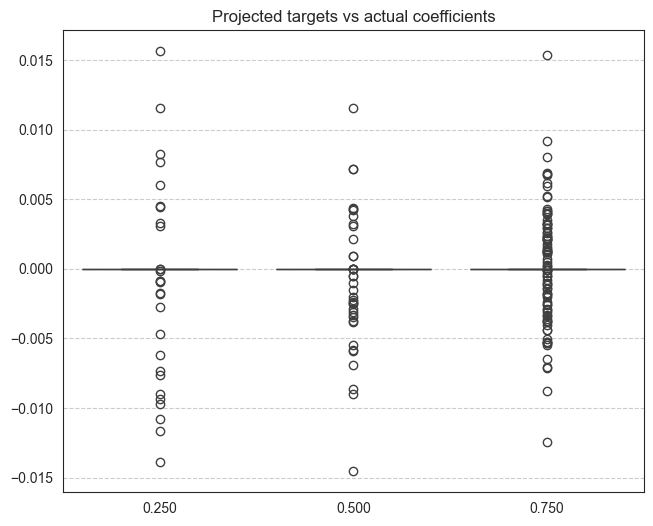

In [80]:
plot_pvals_targets(np.array(oper_char["rho"])[np.array(oper_char["method"])=="Naive"],
                   np.array(oper_char["target"])[np.array(oper_char["method"])=="Naive"])

In [81]:
def plot_ecdf_by_method(values, labels, rho_list):
    values = np.array(values)
    labels = np.array(labels)
    rho_list = np.array(rho_list)
    # Function to calculate ECDF
    def ecdf(data):
        x = np.sort(data)
        n = x.size
        y = np.arange(1, n+1) / n
        return x, y
    
    # Create a 2x2 subplot grid
    fig, axes = plt.subplots(nrows=1, ncols=len(list(np.unique(rho_list))), 
                             figsize=(5*len(list(np.unique(rho_list))), 5))
    i = 0
    for ax in axes.flatten():
        rho = np.unique(rho_list)[i]
        values_i = values[rho_list == rho]
        labels_i = labels[rho_list == rho]
    
        # Create a DataFrame
        df = pd.DataFrame({'Values': values_i, 'Distribution': labels_i})

        # Plotting
        for distribution in df['Distribution'].unique():
            x, y = ecdf(df[df['Distribution'] == distribution]['Values'])
            ax.plot(x, y, marker='.', linestyle='none', label=distribution)
    
        # Add y = x line
        ax.plot([0, 1], [0, 1], 'k--', label='y = x')

        ax.set_title('$rho=$'+str(rho))
        ax.set_xlabel('Value')
        ax.set_ylabel('ECDF')
        ax.axis(xmin=0.,xmax=1, ymin=0., ymax=1)
        ax.legend()
        ax.grid(True)
        i += 1
    # Adjust layout to prevent overlap
    plt.tight_layout()
    #plt.legend(handles, labels, loc='lower center', ncol=4)
    plt.show()
    
def plot_ecdfs(p_values_ll, SNR_list):
    
    if len(SNR_list) > 1:
        # Create a 2x2 subplot grid
        fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10, 8))
        i = 0
        for ax in axes.flatten():
            # Step 2: Sort the data
            data_sorted = np.sort(p_values_ll[i])
        
            # Step 3: Calculate the empirical CDF
            # For each point, the CDF value is the proportion of data points less than or equal to that point
            cdf_values = np.arange(1, len(data_sorted) + 1) / len(data_sorted)
        
            # Step 4: Plot the empirical CDF
            ax.step(data_sorted, cdf_values, where='post', label='Empirical CDF')
            #axes[i].title('Empirical Cumulative Distribution Function')
            # Add a y=x line
            ax.plot(data_sorted, data_sorted, label='Uniform CDF', linestyle='--')
            ax.set_xlabel('Data Points')
            ax.set_xlabel('CDF')
            ax.grid(True)
            ax.legend()
            title = "interaction signal=" + str(SNR_list[i])
            ax.set_title(title)
            i += 1
            
        # Adjust layout to prevent overlap
        plt.tight_layout()
        #plt.legend(handles, labels, loc='lower center', ncol=4)
        plt.show()


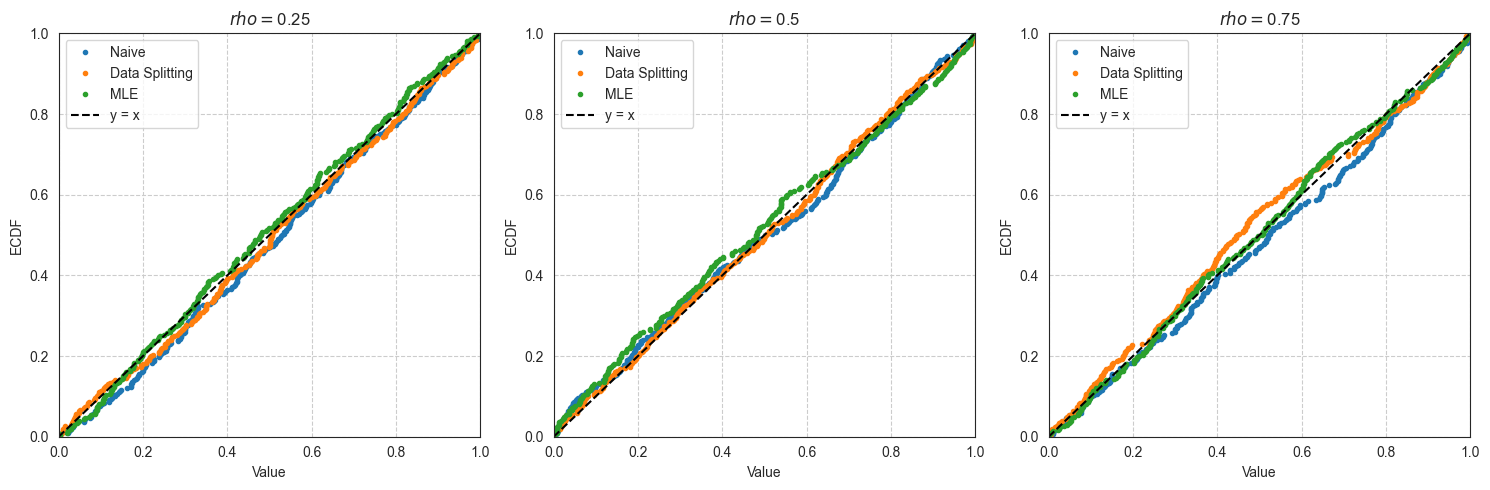

In [82]:
plot_ecdf_by_method(values=oper_char["pval"], labels=oper_char["method"], 
                    rho_list=oper_char["rho"])

In [61]:
oper_char["pval"]

[0.9999999999999999,
 0.9999907512457608,
 0.9999591471247097,
 0.9999999999978809,
 0.9999919551853454,
 0.9999683048375808,
 0.9999999999947238,
 0.9998584255391842,
 0.999419755550528,
 0.9999962752376791,
 0.9999977521346614,
 0.9895552705298635,
 0.9999999998623332,
 0.9999999678835815,
 0.9998263088021246,
 0.9999999947641409,
 0.9998728899428794,
 0.9988963657472251,
 0.9998555080743028,
 0.956222920821909,
 0.9993644857267043,
 0.999524771565426,
 0.9996997401194876,
 0.9966074676595013,
 0.9999619541705648,
 0.9999982674293115,
 0.9945925640199736,
 0.9999921081576767,
 0.9999467463710869,
 0.9958240747688881,
 0.9999999997614553,
 0.999999462474442,
 0.9999503421984665,
 0.9999324816360408,
 0.9884018221106889,
 0.994430512256782,
 0.9999966482023671,
 0.9999999655676461,
 0.9819922360298421,
 0.9999908562341644,
 0.999999231544623,
 0.9981339892863406,
 0.9824146352268538,
 0.8396436744782578,
 0.9774175273810883,
 0.9999999999678654,
 0.9508694965983295,
 0.999999630765238,